In [1]:
import os
# import drjit
gpu_num = 3 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
# common parameters
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters

#### BLER with Jammer Weights Trained on Uncoded Channel

- Single-UE Baseline: Coded channel. Take any Jammer Power which makes sense
    - Uniform Jammer
    - Pilot Jammer
    - All-Data Jammer
    - One-Data Jammer
    - Two-Data Jammer
- Trained Single-UE Jammer trained with same power (in uncoded channel)

In [ ]:
jammer_power = 1.0
# 0-3 silent, 4 pilot, 5-13 data
# Name, shaped_rho
parameters = [
    ("Uniform", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
    ("Pilot", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([1,1]), tf.zeros([9,1])], axis=0))),
    ("One Data Symbol", jammer_power * normalize_power(tf.concat([tf.zeros([5,1]), tf.ones([1,1]), tf.zeros([8,1])], axis=0))),
    ("Two Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([5,1]), tf.ones([2,1]), tf.zeros([7,1])], axis=0))),
    ("All Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([5,1]), tf.ones([9,1])], axis=0))),
]
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 1000
for name, rho in parameters:
    model = Model(**model_parameters, jammer_power=rho)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.1485e-01 | 1.0000e+00 |    11606462 |    36864000 |        32000 |       32000 |       196.3 |reached max iter       
   -3.571 | 3.0877e-01 | 1.0000e+00 |    11382318 |    36864000 |        32000 |       32000 |       181.1 |reached max iter       
   -2.143 | 3.0511e-01 | 1.0000e+00 |    11247578 |    36864000 |        32000 |       32000 |       179.5 |reached max iter       
   -0.714 | 3.0349e-01 | 1.0000e+00 |    11187949 |    36864000 |        32000 |       32000 |       177.9 |reached max iter       
    0.714 | 3.0312e-01 | 1.0000e+00 |    11174241 |    36864000 |        32000 |       32000 |       177.9 |reached max iter       
    2.143 | 3.0365e-01 | 1.0000e+00 |    11193830 |    36864000 |        32000 |     

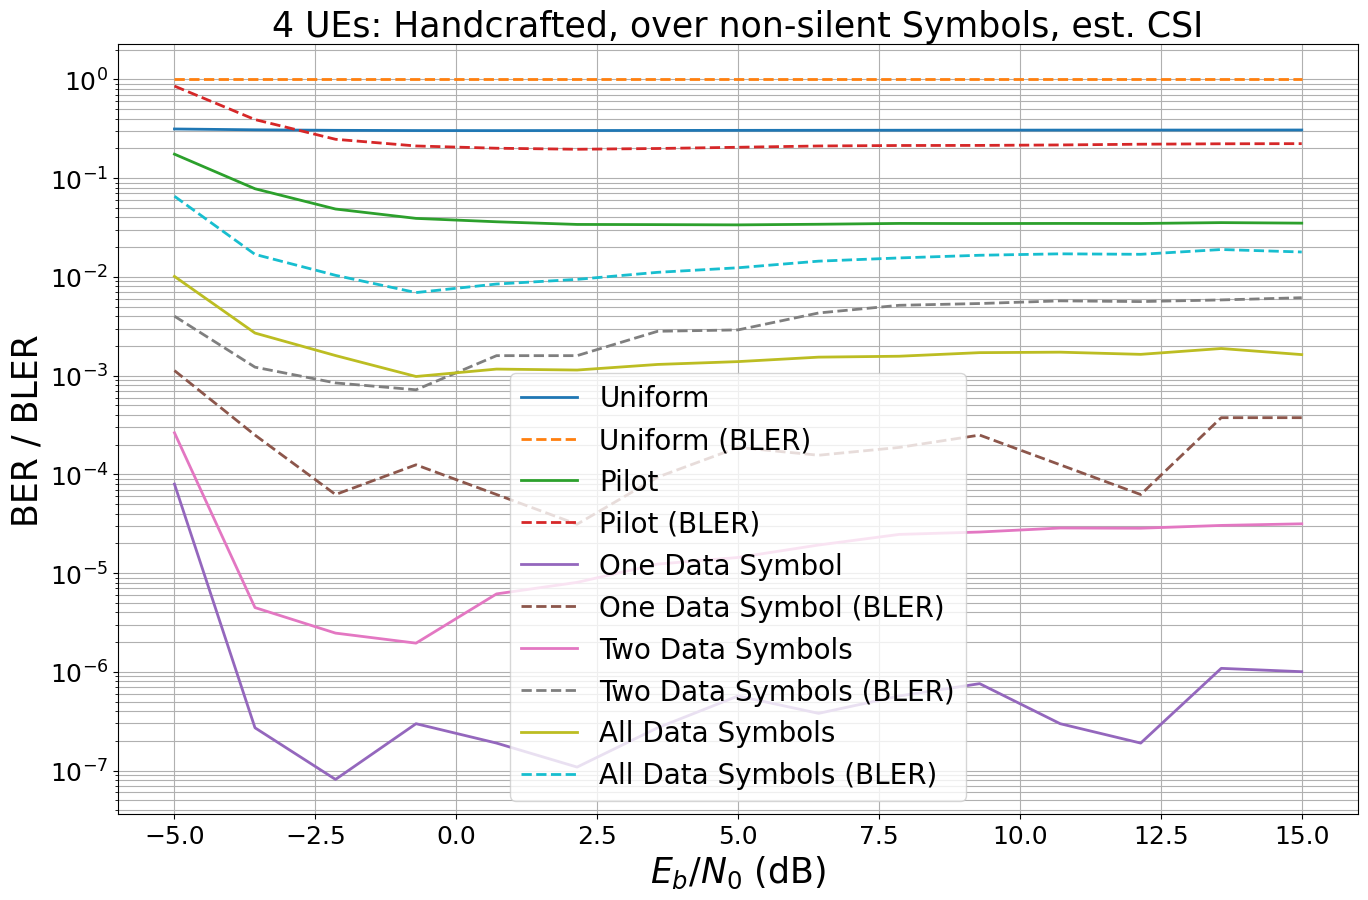

In [ ]:
ber_plots.title = "Handcrafted, over non-silent Symbols, est. CSI"
ber_plots()

In [3]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 300
filename = "weights/ue_1_relufix_symbol_weights.pickle"
my_model_parameters = {**model_parameters,
                       "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
model = Model(**my_model_parameters)
load_weights(model, filename)
simulate_model(model, "1 UE, trained in uncoded channel", add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.8926e-01 | 1.0000e+00 |     4304864 |    11059200 |         9600 |        9600 |        60.2 |reached max iter       
   -3.571 | 3.8761e-01 | 1.0000e+00 |     4286684 |    11059200 |         9600 |        9600 |        52.9 |reached max iter       
   -2.143 | 3.8624e-01 | 1.0000e+00 |     4271544 |    11059200 |         9600 |        9600 |        52.9 |reached max iter       
   -0.714 | 3.8614e-01 | 1.0000e+00 |     4270453 |    11059200 |         9600 |        9600 |        52.4 |reached max iter       
    0.714 | 3.8638e-01 | 1.0000e+00 |     4273054 |    11059200 |         9600 |        9600 |        52.4 |reached max iter       
    2.143 | 3.8683e-01 | 1.0000e+00 |     4278085 |    11059200 |         9600 |     

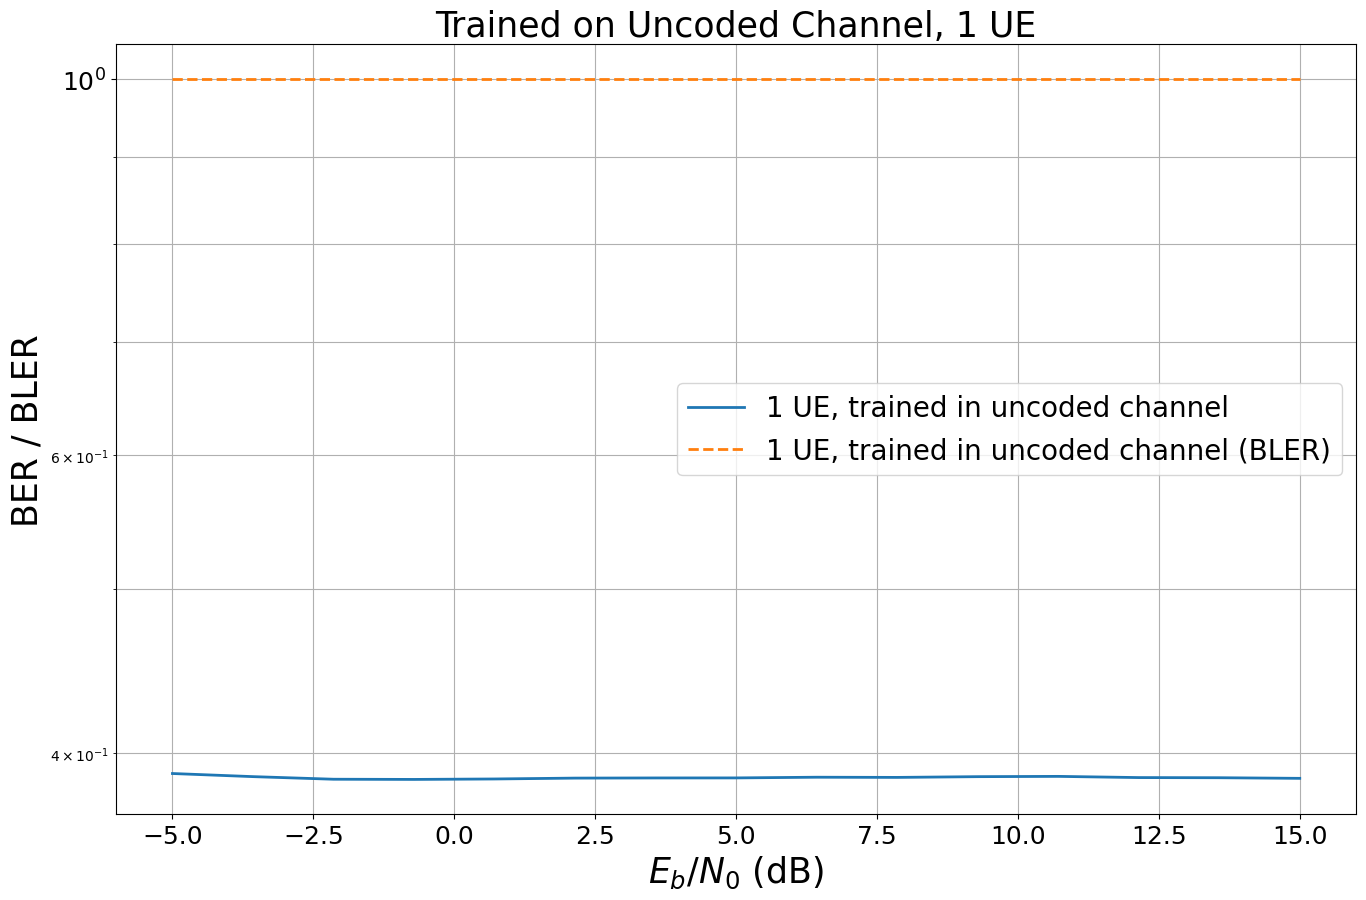

In [4]:
ber_plots.title = "Trained on Uncoded Channel, 1 UE"
ber_plots()

- Multi-UE Baseline: Coded channel. Take any jammer power which makes sense
    - Same as above
- Trained Multi-UE jammer with same power

In [ ]:
ber_plots.reset()
model_parameters["num_ut"] = 4
jammer_power = 1.0
# 0-3 silent, 4 pilot, 5-13 data
# Name, shaped_rho
parameters = [
    ("Uniform", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
    ("Pilot", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([4,1]), tf.zeros([6,1])], axis=0))),
    ("One Data Symbol", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([1,1]), tf.zeros([5,1])], axis=0))),
    ("Two Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([2,1]), tf.zeros([4,1])], axis=0))),
    ("All Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([6,1])], axis=0))),
]
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 1000
for name, rho in parameters:
    model = Model(**model_parameters, jammer_power=rho)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 5.3329e-02 | 7.1291e-01 |     5242408 |    98304000 |        22813 |       32000 |       194.1 |reached max iter       
   -3.571 | 2.7947e-02 | 4.4488e-01 |     2747335 |    98304000 |        14236 |       32000 |       184.7 |reached max iter       
   -2.143 | 1.7938e-02 | 3.0762e-01 |     1763372 |    98304000 |         9844 |       32000 |       182.6 |reached max iter       
   -0.714 | 1.3563e-02 | 2.6259e-01 |     1333337 |    98304000 |         8403 |       32000 |       183.0 |reached max iter       
    0.714 | 1.2130e-02 | 2.6972e-01 |     1192446 |    98304000 |         8631 |       32000 |       184.0 |reached max iter       
    2.143 | 1.1976e-02 | 3.0494e-01 |     1177245 |    98304000 |         9758 |     

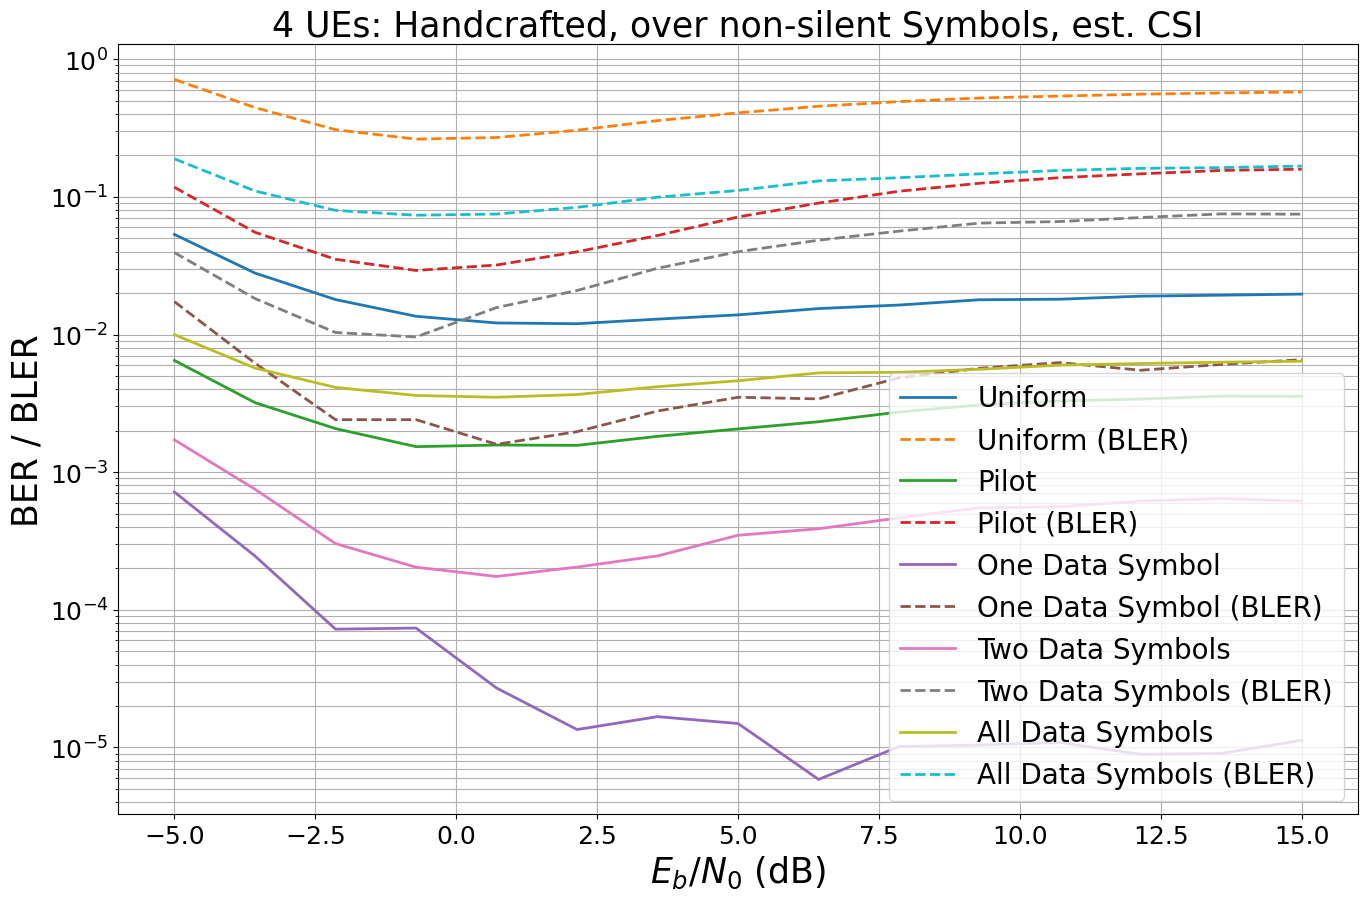

In [ ]:
ber_plots.title = "4 UEs: Handcrafted, over non-silent Symbols, est. CSI"
ber_plots()
# from copy import deepcopy
# ber_plots_copy = deepcopy(ber_plots)
# for i in range(20):
#     ber_plots_copy.remove(0)
# ber_plots_copy()

In [5]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 300
filename = "weights/ue_4_relufix_symbol_weights.pickle"
my_model_parameters = {**model_parameters,
                       "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
model = Model(**my_model_parameters)
load_weights(model, filename)
simulate_model(model, "4 UE, trained in uncoded channel", add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.0550e-02 | 1.3729e-01 |      227263 |    11059200 |         1318 |        9600 |        59.6 |reached max iter       
   -3.571 | 5.9512e-03 | 3.9271e-02 |       65815 |    11059200 |          377 |        9600 |        53.0 |reached max iter       
   -2.143 | 3.2221e-03 | 2.1250e-02 |       35634 |    11059200 |          204 |        9600 |        53.0 |reached max iter       
   -0.714 | 2.3847e-03 | 1.7708e-02 |       26373 |    11059200 |          170 |        9600 |        52.8 |reached max iter       
    0.714 | 2.0511e-03 | 1.8021e-02 |       22684 |    11059200 |          173 |        9600 |        52.6 |reached max iter       
    2.143 | 1.8312e-03 | 1.7812e-02 |       20252 |    11059200 |          171 |     

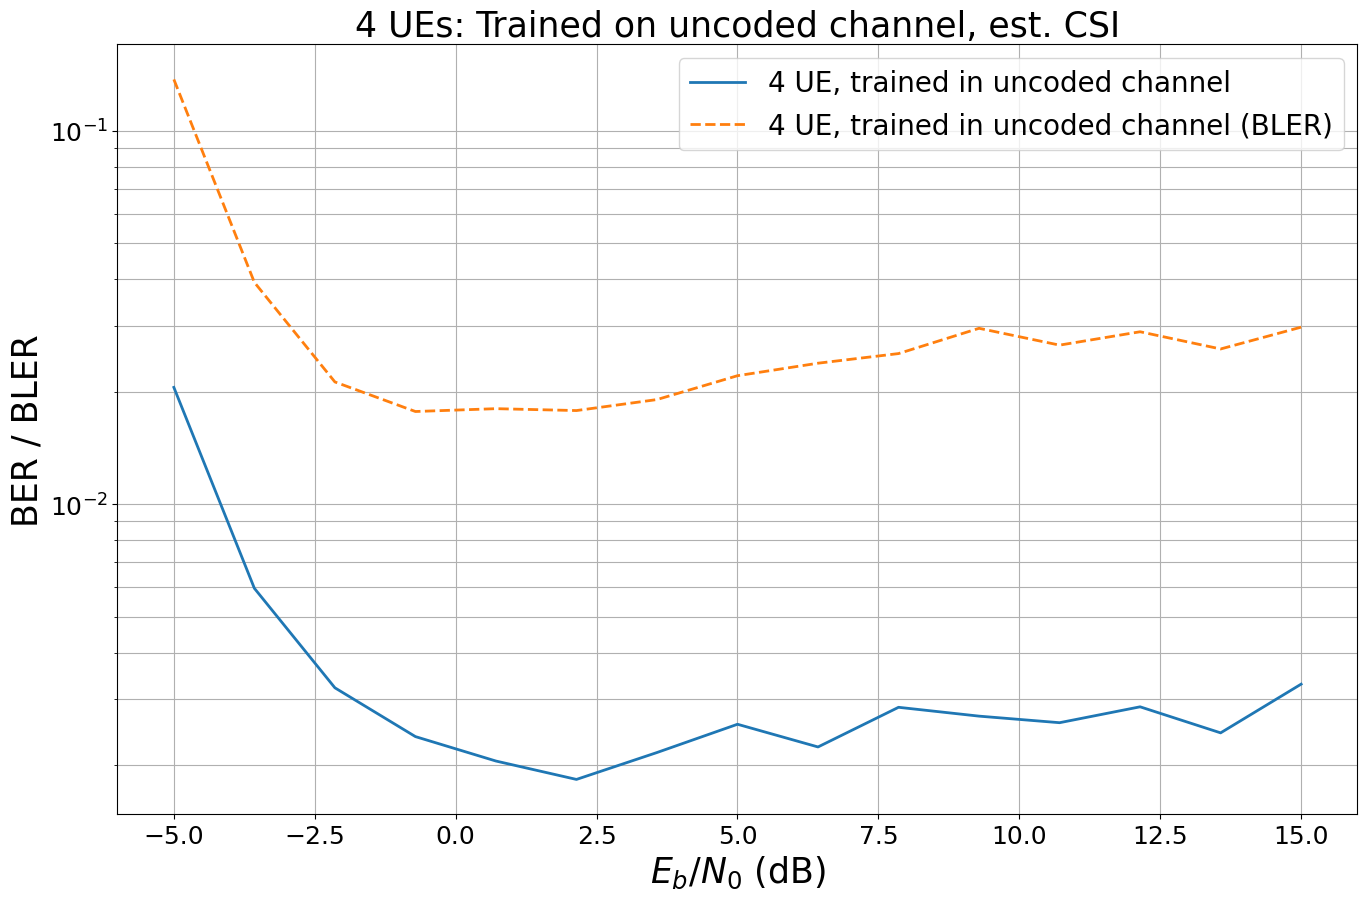

In [6]:
ber_plots.title = "4 UEs: Trained on uncoded channel, est. CSI"
ber_plots()

In [3]:
# trained in uncoded vs handcrafted
ber_plots.reset()
model_parameters["num_ut"] = 4
decoder_parameters["cn_type"] = "minsum"
# model = Model(**model_parameters)
# model._decoder.llr_max = 1000
jammer_power = 1.0
# 0-3 silent, 4 pilot, 5-13 data
# Name, shaped_rho
parameters = [
    ("Uniform", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
    ("Pilot", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([4,1]), tf.zeros([6,1])], axis=0))),
    ("One Data Symbol", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([1,1]), tf.zeros([5,1])], axis=0))),
    ("Two Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([2,1]), tf.zeros([4,1])], axis=0))),
    ("All Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([6,1])], axis=0))),
]
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 200
for name, rho in parameters:
    model = Model(**model_parameters, jammer_power=rho)
    model._decoder.llr_max = 1000
    simulate_model(model, name, add_bler=True)

# vs. trained
filename = "weights/ue_4_relufix_symbol_weights.pickle"
my_model_parameters = {**model_parameters,
                       "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
model = Model(**my_model_parameters)
model._decoder.llr_max = 1000
load_weights(model, filename)
simulate_model(model, "Trained in uncoded channel", add_bler=True)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 7.7366e-02 | 8.3320e-01 |    12168574 |   157286400 |        42660 |       51200 |       109.5 |reached max iter       
   -3.667 | 3.8332e-02 | 5.3709e-01 |     6029024 |   157286400 |        27499 |       51200 |        89.0 |reached max iter       
   -2.333 | 2.2819e-02 | 3.5035e-01 |     3589099 |   157286400 |        17938 |       51200 |        88.4 |reached max iter       
     -1.0 | 1.6056e-02 | 2.5391e-01 |     2525385 |   157286400 |        13000 |       51200 |        89.2 |reached max iter       
    0.333 | 1.2431e-02 | 1.9988e-01 |     1955168 |   157286400 |        10234 |       51200 |        88.7 |reached max iter       
    1.667 | 1.0612e-02 | 1.7152e-01 |     1669148 |   157286400 |         8782 |     

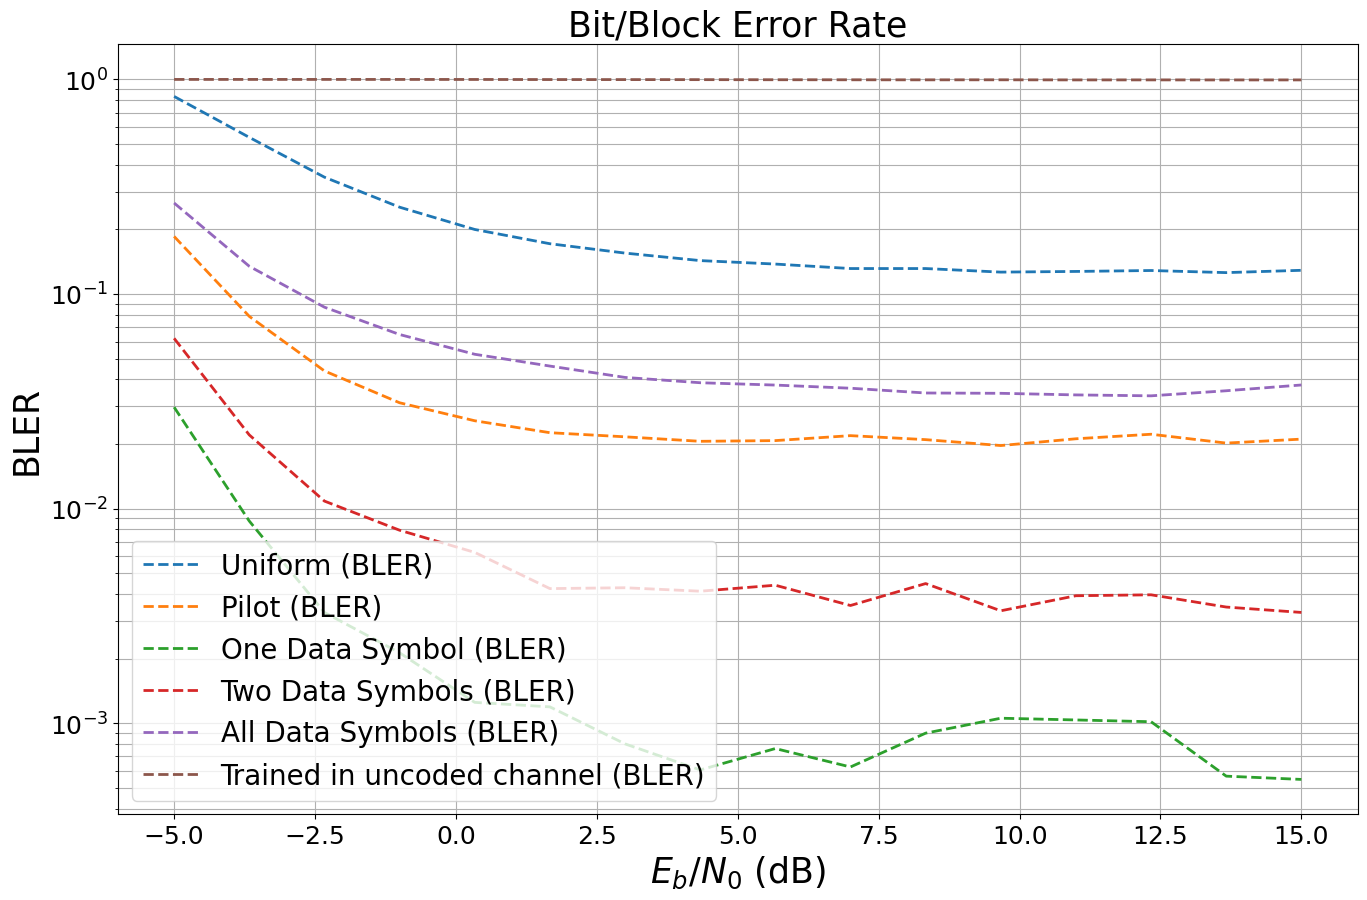

In [5]:
ber_plots(show_ber=False)

#### BLER with Jammer Weights Trained on Information Bits of Coded Channel

- take same power as above and train
    - single-UE
    - multi-UE

We trained with many decoder parameters to see in which cases it has trouble to converge. The following plot is just to evaluate this, hence we also only plot the coded BER.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7899e-01 | 1.0000e+00 |     2095681 |     5529600 |         4800 |        4800 |        26.0 |reached max iter       
   -3.571 | 3.7632e-01 | 1.0000e+00 |     2080890 |     5529600 |         4800 |        4800 |        18.8 |reached max iter       
   -2.143 | 3.7438e-01 | 1.0000e+00 |     2070155 |     5529600 |         4800 |        4800 |        19.8 |reached max iter       
   -0.714 | 3.7346e-01 | 1.0000e+00 |     2065080 |     5529600 |         4800 |        4800 |        19.6 |reached max iter       
    0.714 | 3.7288e-01 | 1.0000e+00 |     2061869 |     5529600 |         4800 |        4800 |        19.2 |reached max iter       
    2.143 | 3.7261e-01 | 1.0000e+00 |     2060366 |     5529600 |         4800 |     

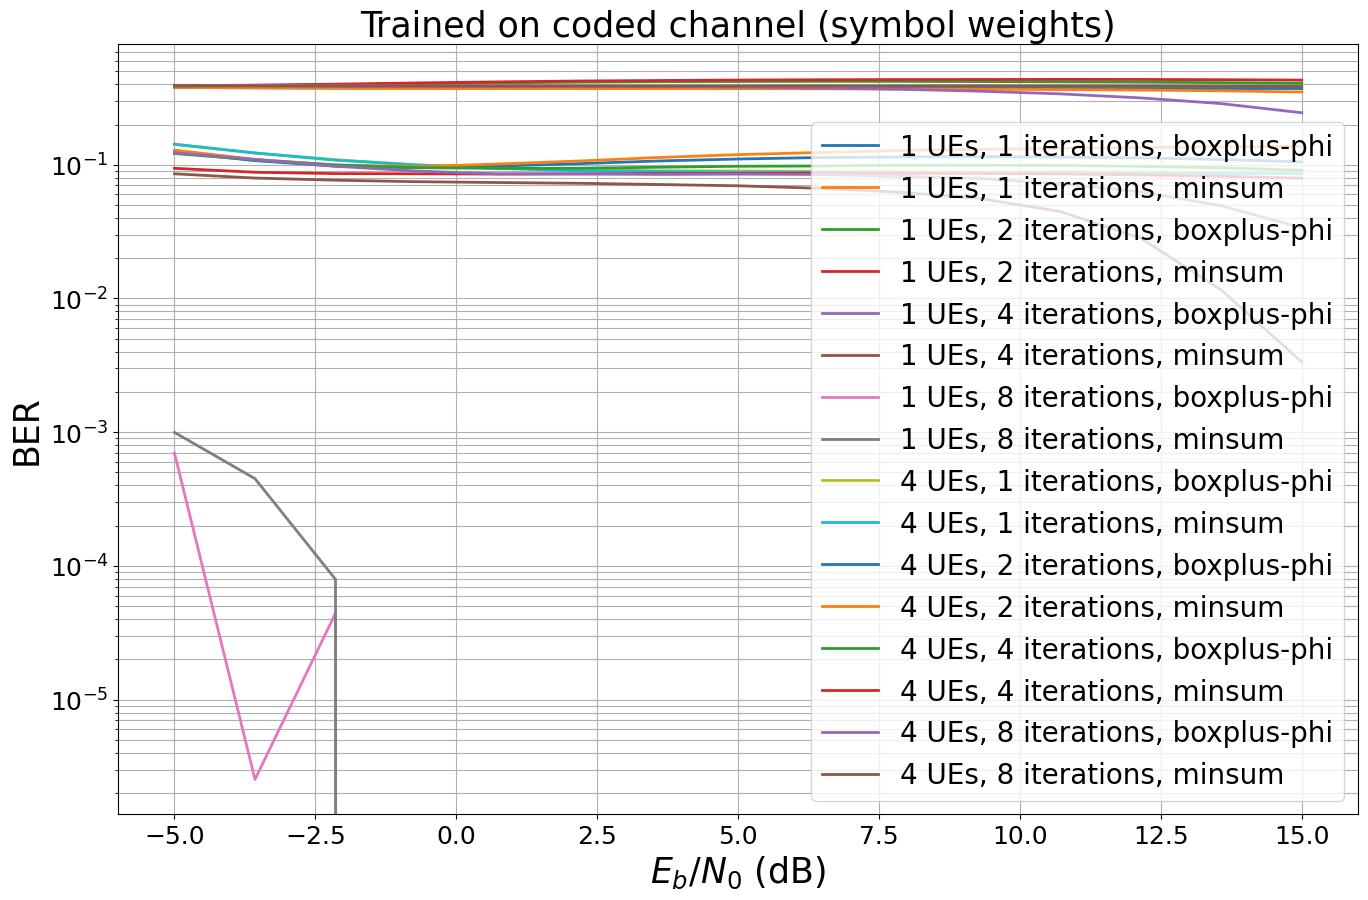

In [4]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 150

num_uts = [1, 4]
num_iters = [1, 2, 4, 8]
cn_types = ["boxplus-phi", "minsum"]
parameters = [(x, y, z) for x in num_uts for y in num_iters for z in cn_types]

for num_ut, num_iter, cn_type in parameters:
    filename = f"weights/coded/symbol/ue_{num_ut}_{cn_type}_{num_iter}_iter.pickle"
    my_model_parameters = {**model_parameters,
                           "num_ut": num_ut,
                           "decoder_parameters": {"num_iter": num_iter, "cn_type": cn_type},
                           "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
    model = Model(**my_model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{num_ut} UEs, {num_iter} iterations, {cn_type}")

ber_plots.title = f"Trained on coded channel (symbol weights)"
ber_plots()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7487e-01 | 1.0000e+00 |     2072899 |     5529600 |         4800 |        4800 |        26.2 |reached max iter       
   -3.571 | 3.7123e-01 | 1.0000e+00 |     2052732 |     5529600 |         4800 |        4800 |        19.4 |reached max iter       
   -2.143 | 3.6899e-01 | 1.0000e+00 |     2040370 |     5529600 |         4800 |        4800 |        19.4 |reached max iter       
   -0.714 | 3.6743e-01 | 1.0000e+00 |     2031737 |     5529600 |         4800 |        4800 |        19.4 |reached max iter       
    0.714 | 3.6590e-01 | 1.0000e+00 |     2023290 |     5529600 |         4800 |        4800 |        19.5 |reached max iter       
    2.143 | 3.6368e-01 | 1.0000e+00 |     2010993 |     5529600 |         4800 |     

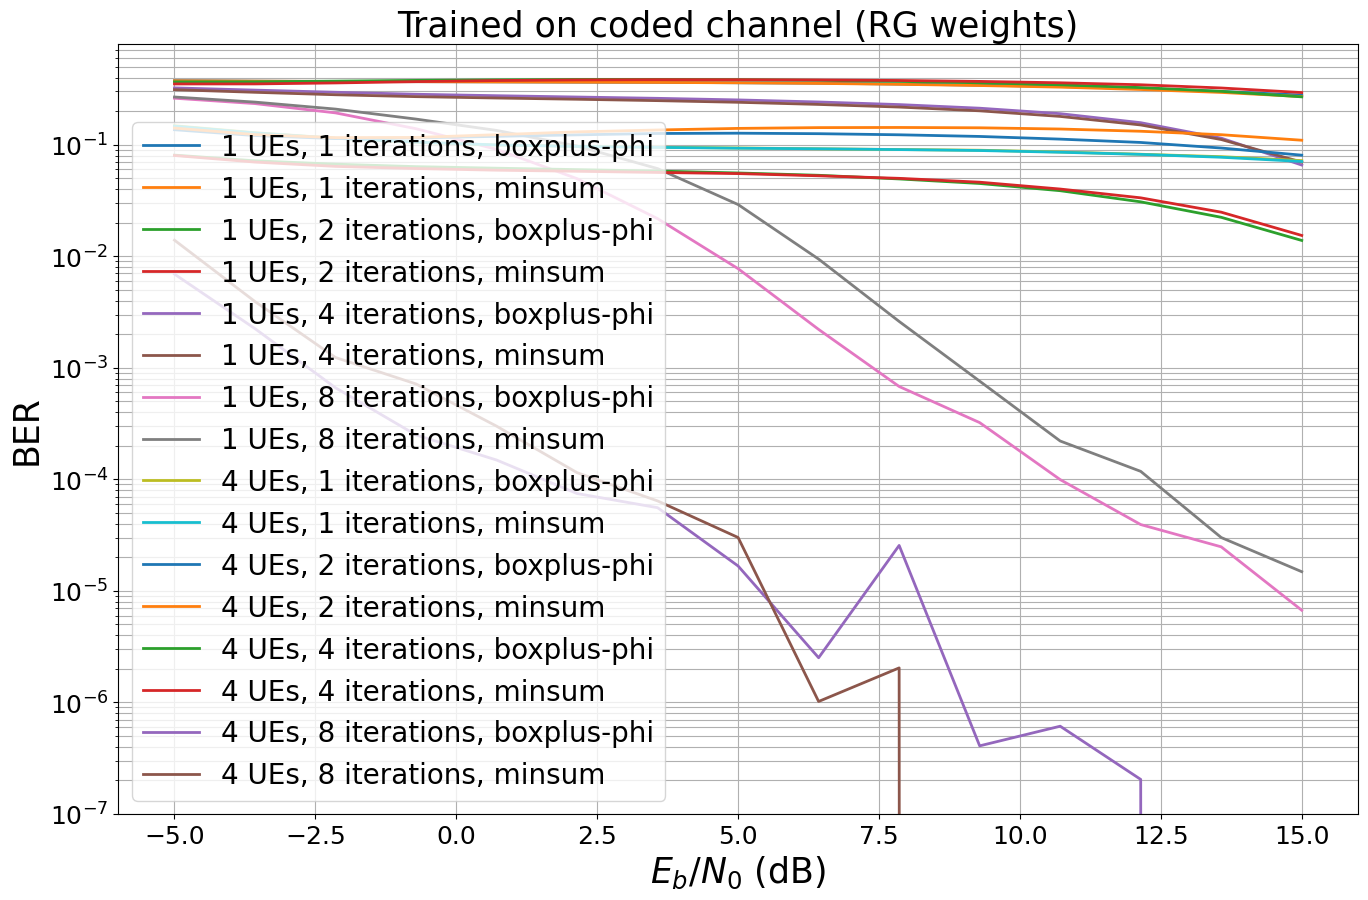

In [6]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 150

num_uts = [1, 4]
num_iters = [1, 2, 4, 8]
cn_types = ["boxplus-phi", "minsum"]
parameters = [(x, y, z) for x in num_uts for y in num_iters for z in cn_types]

for num_ut, num_iter, cn_type in parameters:
    filename = f"weights/coded/rg/ue_{num_ut}_{cn_type}_{num_iter}_iter.pickle"
    my_model_parameters = {**model_parameters,
                           "num_ut": num_ut,
                           "decoder_parameters": {"num_iter": num_iter, "cn_type": cn_type},
                           "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,128], dtype=tf.bool)}}
    model = Model(**my_model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{num_ut} UEs, {num_iter} iterations, {cn_type}")

ber_plots.title = f"Trained on coded channel (RG weights)"
ber_plots()

The training graphs show that _minsum_ is easier to train in difficult cases, otherwise it's about the same. We will hence use _minsum_ for training purposes and _boxplus-phi_ for inference.

### Trained weights in coded channel with iteration loss

In [8]:
jammer_power = 1.0
parameters = [
    ("Uniform, 1 UE", 1, jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
    ("Uniform, 4 UEs", 4, jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
]
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 1000
my_model_parameters = {**model_parameters,
                        "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)},
                        "decoder_parameters": {"num_iter": 8, "cn_type": "boxplus-phi"}}
for name, num_ut, rho in parameters:
    model = Model(**{**my_model_parameters, "num_ut": num_ut, "jammer_power": rho})
    simulate_model(model, name, add_bler=True)

parameters = [
    ("Trained, 1 UE", 1,
     f"weights/coded/symbol/iteration_loss_2/ue_1_alpha_0.9_exp_False_8_iter.pickle"),
    ("Trained, 4 UEs", 4,
     f"weights/coded/symbol/iteration_loss_2/ue_4_alpha_0.5_exp_False_8_iter.pickle"),
]
for name, num_ut, filename in parameters:
    model = Model(**{**my_model_parameters, "num_ut": num_ut})
    load_weights(model, filename)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.1488e-01 | 1.0000e+00 |    11607882 |    36864000 |        32000 |       32000 |       168.5 |reached max iter       
   -3.571 | 3.0877e-01 | 1.0000e+00 |    11382382 |    36864000 |        32000 |       32000 |       154.7 |reached max iter       
   -2.143 | 3.0512e-01 | 1.0000e+00 |    11248004 |    36864000 |        32000 |       32000 |       152.3 |reached max iter       
   -0.714 | 3.0351e-01 | 1.0000e+00 |    11188480 |    36864000 |        32000 |       32000 |       150.5 |reached max iter       
    0.714 | 3.0327e-01 | 1.0000e+00 |    11179897 |    36864000 |        32000 |       32000 |       154.5 |reached max iter       
    2.143 | 3.0354e-01 | 1.0000e+00 |    11189881 |    36864000 |        32000 |     

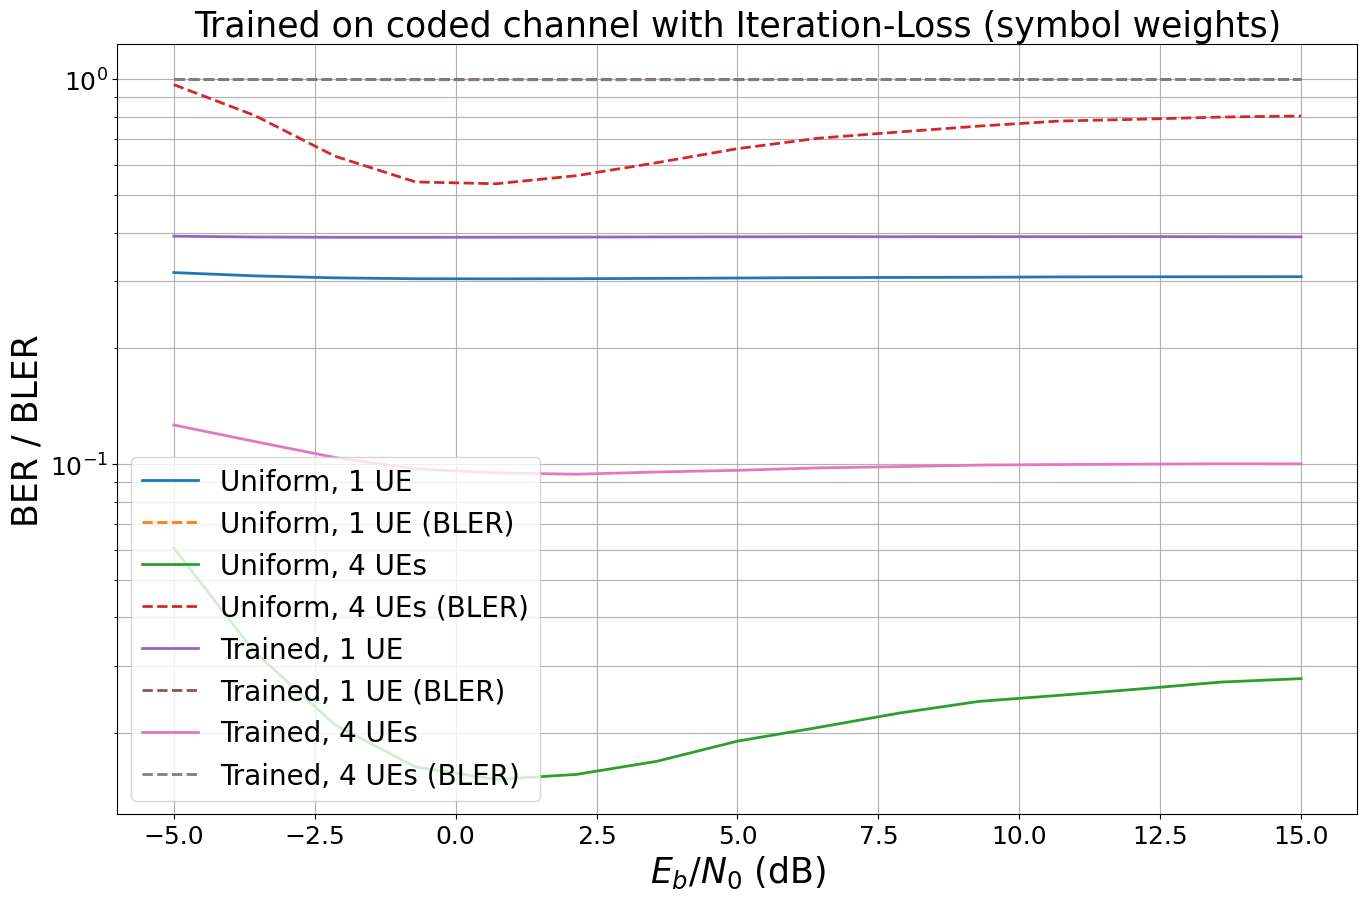

In [17]:
ber_plots.title = f"Trained on coded channel with Iteration-Loss (symbol weights)"
ber_plots()